# SPARK Dataset


## Imports

In [1]:
from spark_utils import PyTorchSparkDataset, SPARKDataset
from matplotlib import pyplot as plt
from random import randint
import os


In [2]:
import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()


## Defining the Dataset

By default, the output structure of the dataset is not compatible with the models or the transforms (https://pytorch.org/vision/master/transforms.html#v1-or-v2-which-one-should-i-use). To overcome that, we wrap a `PyTorchSparkDataset` in`PyTorchSparkDatasetV2`.

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`. Our dataset now returns a target which is dict where the values are `TVTensors` (all are `torch.Tensor` subclasses).

We also make the dataset compliant with COCO requirements so that it will work for both training and evaluation codes from the COCO reference script.

In [3]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2
class PyTorchSparkDatasetV2(torch.utils.data.Dataset):
    def __init__(
        self,
        class_map,
        split="train",
        root_dir="./data/",
        transforms=None,
        sample_size=1,
    ):
        self.dataset = PyTorchSparkDataset(
            class_map, split=split, root_dir=root_dir, sample_size=sample_size
        )
        self.transforms = transforms
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.split == "test":
            img, img_name = self.dataset[idx]
            img = tv_tensors.Image(img)

            if self.transforms is not None:
                img = self.transforms(img)

            return img, img_name

        else:
            img, label, bbox = self.dataset[idx]

            img = tv_tensors.Image(img)

            bbox = tv_tensors.BoundingBoxes(
                bbox, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=F.get_size(img)
            )
            label = torch.tensor([label])
            area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)
            image_id = idx

            target = {
                "boxes": bbox,
                "labels": label,
                "area": area,
                "iscrowd": iscrowd,
                "image_id": image_id,
            }

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target


## Transforms

Let’s now define our pre-processing transforms. All the transforms know how to handle images, bouding boxes and masks when relevant.

Transforms are typically passed as the transforms parameter of the dataset so that they can leverage multi-processing from the `torch.utils.data.DataLoader`.

If the data is intended for training, a series of augmentation techniques are used. These include `RandomPhotometricDistort` to apply random color distortions (this helps the model generalize better across varying lighting conditions), and `RandomZoomOut` which randomly zooms out of the image (creating new perspectives and scales for the model to learn from).

The `RandomIoUCrop` performs a random crop based on the intersection-over-union (IoU) of the bounding boxes, and `RandomHorizontalFlip` and `RandomVerticalFlip` randomly flips the image horizontally and vertically (increasing the diversity of orientations). The `SanitizeBoundingBoxes` function adjusts and sanitizes the bounding boxes after these transformations are applied.

- http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example
- https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [4]:
# Define the transforms to be applied to the data.
def get_transform(split):
    """Defines tranforms for datasets."""
    transforms = []
    transforms.append(T.ToImage())

    if split == "train":
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(
            T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0})
        )
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
        transforms.append(T.Resize((64, 64)))  # Remove this line
        transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)


## Loading Datasets

In [5]:
def get_dataset(split, class_map, data_path, sample_size=1):
    """Returns dataset."""
    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(
        class_map=class_map,
        split=split,
        root_dir=data_path,
        transforms=get_transform(split),
        sample_size=sample_size,
    )
    return dataset


In [6]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = "./data/"

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {
    "proba_2": 0,
    "cheops": 1,
    "debris": 2,
    "double_star": 3,
    "earth_observation_sat_1": 4,
    "lisa_pathfinder": 5,
    "proba_3_csc": 6,
    "proba_3_ocs": 7,
    "smart_1": 8,
    "soho": 9,
    "xmm_newton": 10,
}

# Define the number of classes
num_classes = len(class_map)

# # Define the datasets for training validation and testing
dataset = get_dataset(
    split="train", class_map=class_map, data_path=data_path, sample_size=0.01
)
dataset_valid = get_dataset(
    split="validation", class_map=class_map, data_path=data_path, sample_size=0.01
)
dataset_test = get_dataset(
    split="test", class_map=class_map, data_path=data_path
)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")
print(f"Number of test samples: {len(dataset_test)}\n")


Number of training samples: 660
Number of validation samples: 220

Number of test samples: 22000



In [7]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")


Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 64, 64])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels', 'area', 'iscrowd', 'image_id']

Boxes type: <class 'torch.Tensor'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


/mnt/irisgpfs/users/dgareev/compvision_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Visualizing Images

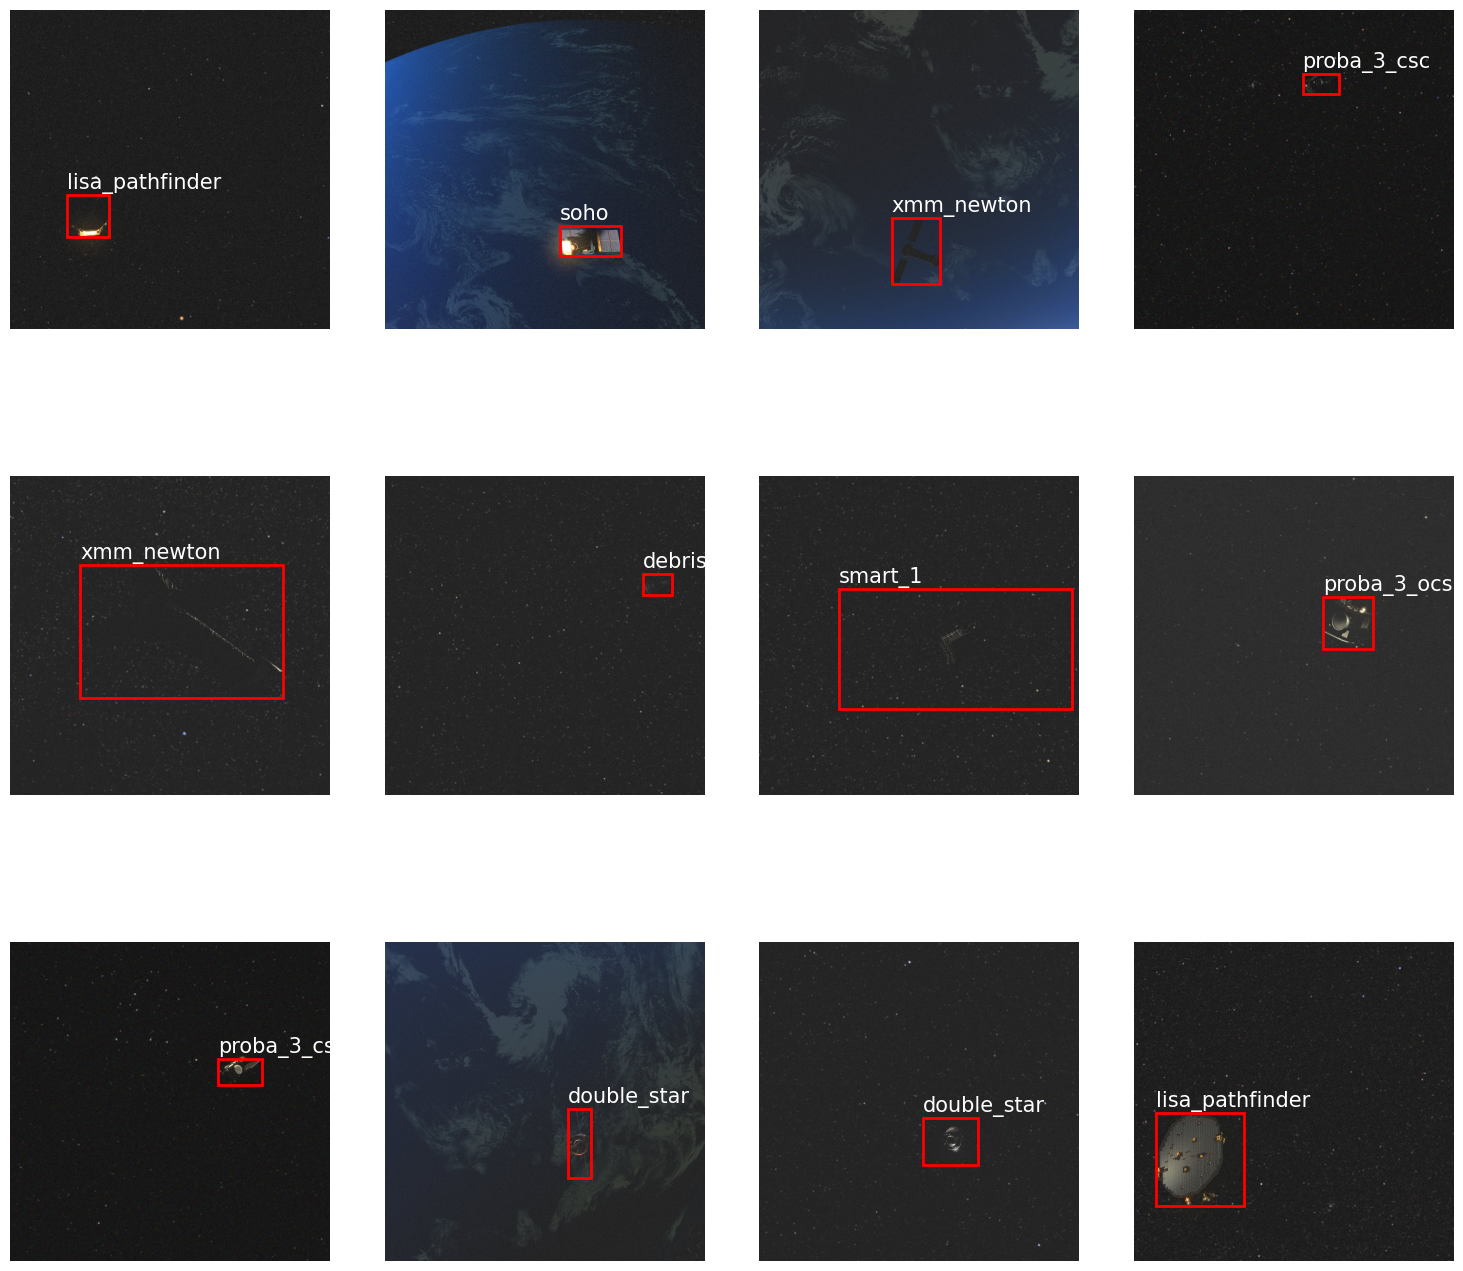

In [10]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="train")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()


## Define Dataloaders

In [11]:
# Define the batch size to be used.
batch_size = 2

# Define the dataloaders for training, validation and testing.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=lambda batch: tuple(zip(*batch)),
)


## Defining Model

We will be using Faster R-CNN V2. Faster R-CNN V2 is a model that predicts both bounding boxes and class scores for potential objects in the image. It works similarly to Faster R-CNN with ResNet-50 FPN backbone.

We will start from a model pre-trained on COCO and finetune it for our particular classes in order to perform transfer learning.

- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [12]:
# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


## Model Training

Below is the main function which performs the training and the validation.

In [13]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)


/mnt/irisgpfs/users/dgareev/compvision_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: [0]  [  0/330]  eta: 0:16:59  lr: 0.000020  loss: 2.5785 (2.5785)  loss_classifier: 2.4556 (2.4556)  loss_box_reg: 0.0625 (0.0625)  loss_objectness: 0.0529 (0.0529)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 3.0904  data: 0.1371  max mem: 3687
Epoch: [0]  [100/330]  eta: 0:01:29  lr: 0.001538  loss: 0.2179 (0.6080)  loss_classifier: 0.1081 (0.4674)  loss_box_reg: 0.0653 (0.0657)  loss_objectness: 0.0303 (0.0668)  loss_rpn_box_reg: 0.0064 (0.0080)  time: 0.3471  data: 0.1492  max mem: 3849
Epoch: [0]  [200/330]  eta: 0:00:49  lr: 0.003057  loss: 0.2514 (0.4330)  loss_classifier: 0.1243 (0.2939)  loss_box_reg: 0.0909 (0.0751)  loss_objectness: 0.0300 (0.0552)  loss_rpn_box_reg: 0.0052 (0.0089)  time: 0.3544  data: 0.1542  max mem: 3849
Epoch: [0]  [300/330]  eta: 0:00:10  lr: 0.004575  loss: 0.2562 (0.3725)  loss_classifier: 0.1198 (0.2352)  loss_box_reg: 0.1098 (0.0811)  loss_objectness: 0.0138 (0.0471)  loss_rpn_box_reg: 0.0035 (0.0091)  time: 0.3451  data: 0.1464  max mem: 3849


## Compute Predictions

In [16]:
# Switch the model to evaluation mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Each image processed by the model could potentially have multiple bounding boxes predicted, each with a confidence score. However, in this script, we've implemented a strategy to keep the prediction process simple and focused. Instead of considering multiple bounding boxes per image, we only take the bounding box with the highest confidence score. This means that for each image, we are predicting a single bounding box, that is, the one that the model is most certain about.

The script also handles cases where no bounding boxes are predicted for an image. In such cases, it records an empty bounding box and class label.


In [17]:
def get_inverse_class_map(class_map):
    """Returns a dictionary that maps integer labels to class names."""
    return {v: k for k, v in class_map.items()}

# Create the inverse class map.
inverse_class_map = get_inverse_class_map(class_map)

def process_predictions(predictions):
    """Processes predictions to keep only the bounding box with the highest score."""
    for i, prediction in enumerate(predictions):
        if prediction['scores'].numel() > 0:
            max_score_index = prediction['scores'].argmax()
            predictions[i] = {key: val[max_score_index].unsqueeze(0) for key, val in prediction.items()}
    return predictions

def write_prediction_to_file(f, prediction, img_name):
    """Writes a single prediction to the file."""
    if prediction['scores'].numel() > 0:
        box = list(map(int, prediction["boxes"].cpu().numpy().squeeze()))
        label = int(prediction["labels"].cpu().numpy().squeeze())
        class_name = inverse_class_map[label]  # Convert the integer label to a class name.
        box_str = str(box)  # Convert the bounding box coordinates to a string.
    else:
        box_str, class_name = '', ''

    f.write(f'"{img_name}",{class_name},"{box_str}"\n')


The predictions are then written to a CSV file, with each line in the file corresponding to one image from the test dataset. Each line contains the image name, the predicted class label, and the coordinates of the predicted bounding box.


In [18]:
# Define the CSV file path
csv_file_path = os.path.join(data_path, 'predictions.csv')

# Open the CSV file and write the header
with open(csv_file_path, "w") as f:
    f.write("filename,class,bbox\n")

# Loop over the test dataset
for i, (images, img_names) in enumerate(data_loader_test):

    # TODO: Remove this after testing
    if i == 100:
        break

    # Move the images to the device
    images = [image.to(device) for image in images]

    # Compute the model predictions
    with torch.no_grad():
        predictions = model(images)

    # Process predictions to keep only the bounding box with the highest score
    predictions = process_predictions(predictions)

    # Open the CSV file in append mode and write the predictions
    with open(csv_file_path, "a") as f:
        for prediction, img_name in zip(predictions, img_names):
            write_prediction_to_file(f, prediction, img_name)


## Visualizing Predictions

What do the predictions look like? Let’s take a look at some images in the dataset and verify

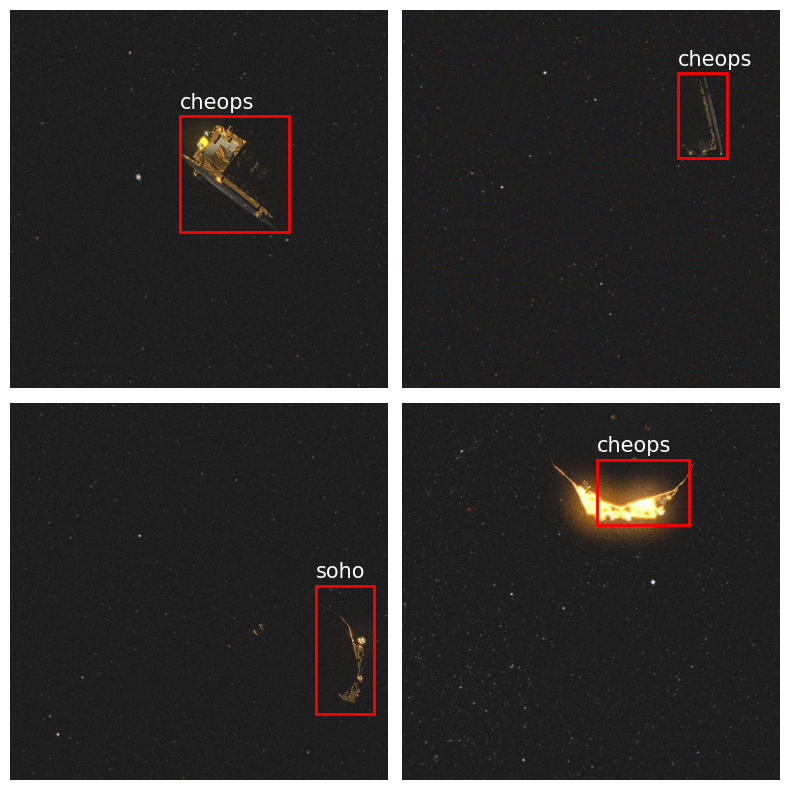

In [28]:
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="predictions")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()
